#Лабораторная работа №3.1
#Вариант 29 (PReLU, Гиперболический тангенс, SGD).
#Едленко Сергей гр 4.6.  

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import torch.nn as nn
import torch.nn.functional as F
import torch

$f(x,y) = - \left(\dfrac{3}{(x^2+ 8)} + \dfrac{5}{(y^2+ 8)}\right)$

In [ ]:
#функция
def f(x,y):
    return -((3 / (x*x + 8)) + (5 / (y*y + 8)))

In [ ]:
#Функция отрисовки графика
def paint(X, Y, Z):
  fig = plt.figure(figsize=plt.figaspect(0.5), dpi=300)

  ax = fig.add_subplot(1, 2, 1, projection='3d')

  ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=True)
  ax = fig.add_subplot(1, 2, 2, projection='3d')

  ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)

In [ ]:
#Класс нейросети
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(2, 30)
    self.fc2 = nn.Linear(30, 30)
    self.fc3 = nn.Linear(30, 1)

  def forward(self, x):
    x = F.tanh(self.fc1(x))
    x = F.prelu(self.fc2(x))
    x = self.fc3(x)
    return x

In [ ]:
#Константы
LEARNING_RATE      = 0.02
MOMENTUM           = 0.9
BATCH_SIZE         = 20
ALLOWABLE_ERROR    = 0.01
CORRECTIVE_STEP    = 100
LOG_INTERVAL       = 100


In [ ]:
nn = nn.Sequential(
    nn.Linear(2, 30),
    nn.Tanh(),
    nn.Linear(30, 30),
    nn.PReLU(),
    nn.Linear(30, 1)
)

In [ ]:
#Создаем оптимизатор SGD
learning_rate = LEARNING_RATE
optimizer = torch.optim.SGD(nn.parameters(), lr=learning_rate, momentum = MOMENTUM)
# Создаем функцию потерь

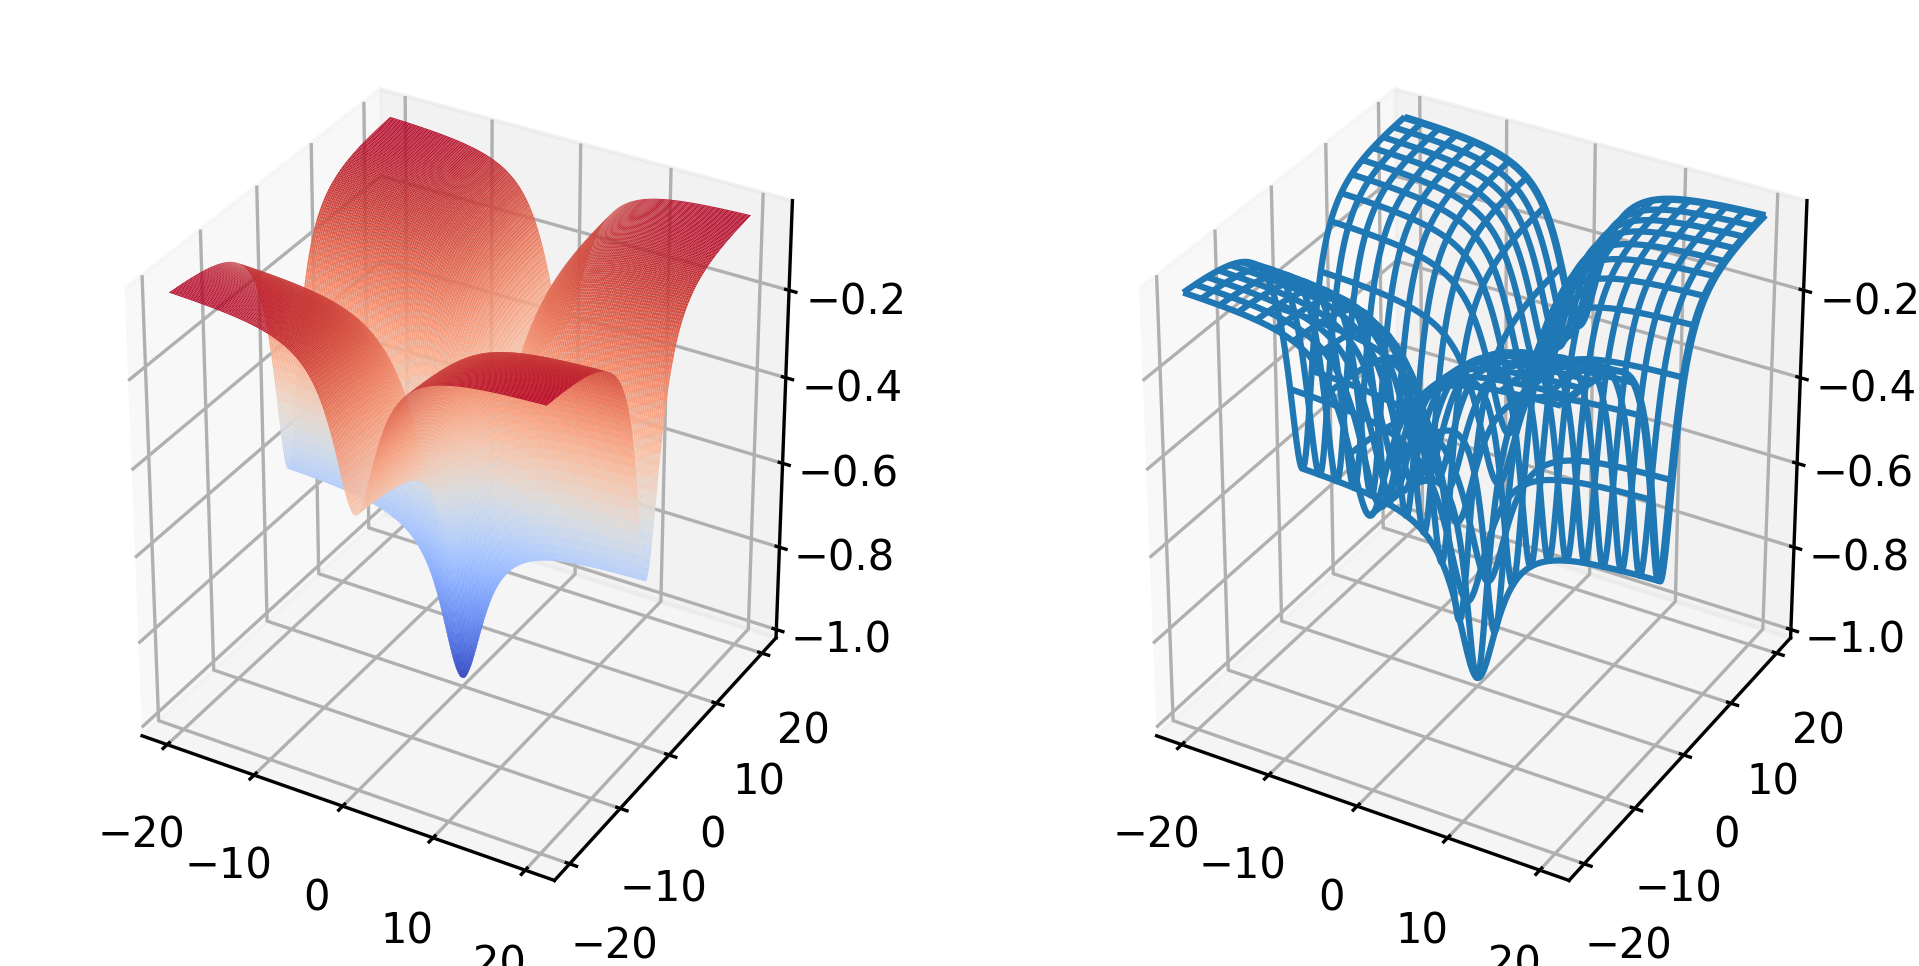

In [ ]:
#Генерируем случайный датасет
X = torch.arange(-20, 20.25, 0.2)
Y = torch.arange(-20, 20.25, 0.2)
X, Y = torch.meshgrid(X, Y, indexing='xy')

#Рисуем график
Z = f(X, Y)
paint(X.cpu().detach().numpy(), Y.cpu().detach().numpy(), Z.cpu().detach().numpy()) 



In [ ]:
# приводим к одномерному массиву
X1 = X.flatten()
Y1 = Y.flatten()

tensor_x = torch.stack([X1, Y1], dim=1)
tensor_y = Z.reshape(-1,1)

loss = torch.nn.L1Loss(reduction = 'mean')
# первоначальная ошибка
loss_dt = loss(nn.forward(tensor_x), tensor_y)
# Эпохи
epoch = 0

In [ ]:
while loss_dt.item() > ALLOWABLE_ERROR:
  epoch += 1
  # перемешиваем значения на входе
  order = torch.randperm(tensor_x.shape[0])

  #Обучаемся по батчам
  for start_index in range(0, tensor_x.shape[0], BATCH_SIZE):

      optimizer.zero_grad() # обнуляем градиент
      batch_indexes = order[start_index:start_index+BATCH_SIZE] # берем индексы для батча

      if batch_indexes.shape[0] !=BATCH_SIZE:
          break

      #Выбираем батч
      x_batch = tensor_x[batch_indexes]
      z_batch = tensor_y[batch_indexes]

      #Предсказываем
      z_pred = nn.forward(x_batch)
      # считаем лосс
      loss_value = loss(z_pred, z_batch) 
      # считаем градиент
      loss_value.backward() 
      # делаем шаг градиента
      optimizer.step()


  #Предсказываем данные
  test_preds = nn.forward(tensor_x)
  #Сохраняем прошлый loss
  last_loss_value = loss_dt
  loss_dt = loss(test_preds, tensor_y)

  #На случай оврагов
  if (last_loss_value.item() < loss_dt.item() and epoch > CORRECTIVE_STEP):
    learning_rate *= 0.9
    for g in optimizer.param_groups:
      g['lr'] = learning_rate

  if epoch % LOG_INTERVAL == 0:
      print('loss: ', loss_dt)
      #Сохраянем модель
      nn.eval() 

  nn.eval()

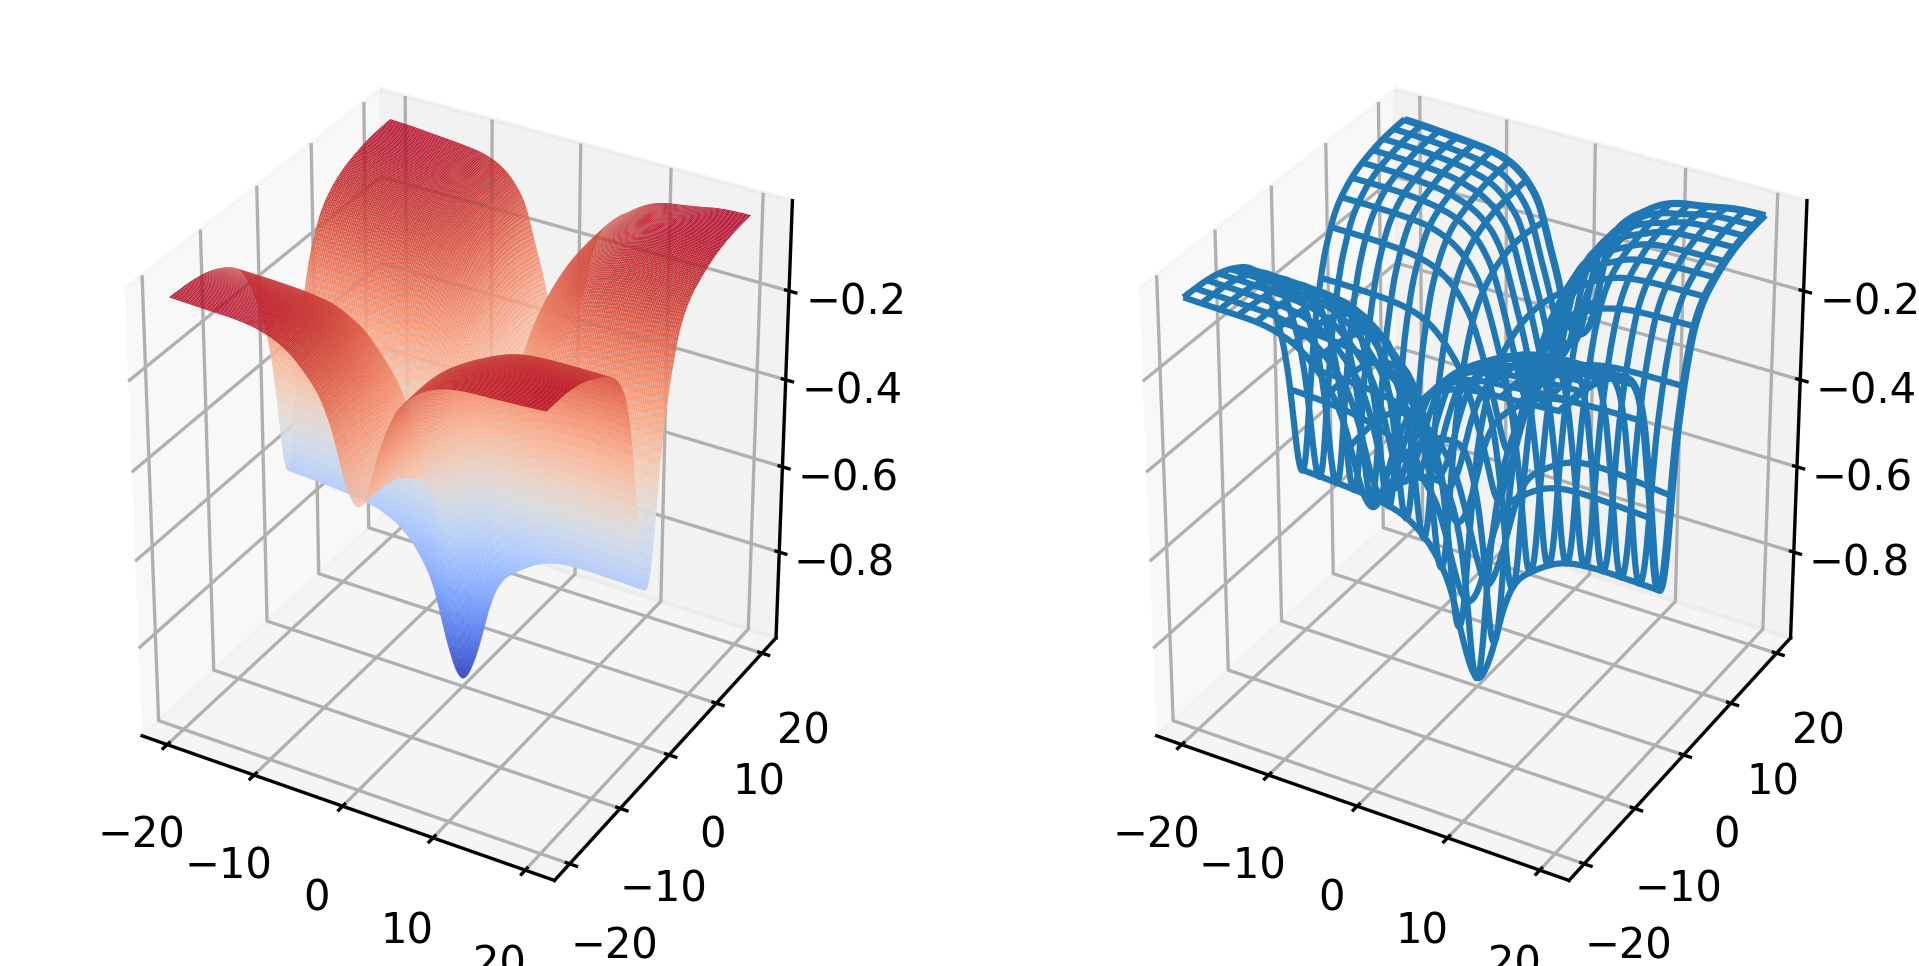

In [ ]:
#график
Z_predict = nn.forward(tensor_x).reshape(202,202)
paint(X.cpu().detach().numpy(), Y.cpu().detach().numpy(), Z_predict.cpu().detach().numpy())